# Overview
From what I have learned, predicting lap times is a crucial responsibility of a strategist. On top of that, being able to understand what feature inputs are valuable in order to train the best performing model is instrumental in being confident about decision making during a race. The strength of a predictive algorithm lies in the feature inputs. Unfortunately, the current accessible data may not result in the strongest predictor, but nonetheless the thought process remains the same. 

An important factor to consider during a race weekend is that conditions can constantly change and evolve, both within a session and from one session to another. 

There are many approaches to performing machine learning regression (using an algorithm that takes feature inputs to predict a numerical value), however selecting the right method is dependent on the granularity and characteristics of the input data avaliable. 

Here I'll outline two methods of Regression, Multiple Linear Regression and Polynomial Regression to predict lap times and pace during the race. I'll use the data gathered by the team during practice, and validate the model against what actually occurred during the race.

Other more involved processes such as using a robust package like XGBoost or other black box algorithms is better suited for much larger datasets. This may be useful when having more data to complement what can be extracted from the API. Data such as fuel load, track/tyre temperatures, track conditions, etc, may be useful inputs for building an XGBoost model. However, due to the limitations of the data collected, the simpler regression model will be used.


## About Multiple Regression

Multiple Regression is based off linear regression, which uses evaluates the relationship between the independent and dependent variable by fitting the "best fit line" between them. This "best fit line" can be used to predict future values. 

Multiple regression however, is the practice of taking multiple independent variables to predict a single outcome variable.

In [2]:
# load packages
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import plotly.express as px
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import scipy.interpolate as interp

Similar to my other data cleaning procedures, I've used SQLite to clean and organize the data from all that was returned from the API.

I have also isolated data collected by the team.

In [23]:
# load all practice sessions from bahrain-21 ++ np times removed
df = pd.read_csv('gp_2021_lap_sector_times_deltas.csv')
# data specific to team
df = df[df["Team"] == 'AlphaTauri']
df = df[df["gp"] == 'Bahrain Grand Prix']
df = df[df["session"] == 'FP2']
df = df[df['track_clear'] == 'yes']
df = df[df['LapNumber'] > 12]
df = df[df.PitInTime.isnull()]
df = df[df.PitOutTime.isnull()]

In [24]:
# isolate columns to be used for model
df = df[["Tyre","TyreLife","LapTime"]]
df = pd.get_dummies(df, columns=["Tyre"])
df = df[[ "Tyre_MEDIUM", "Tyre_SOFT", "TyreLife","LapTime"]]
df.head()

,Tyre_MEDIUM,Tyre_SOFT,TyreLife,LapTime
1336,0,1,9.0,97.170
1344,0,1,10.0,97.494
1353,0,1,11.0,98.572
1363,0,1,12.0,98.647
1372,0,1,13.0,98.635


In [25]:
# check if any null values present
df.isnull().values.any()

False

In [26]:
# split data, predictors and target variable
X = df[["Tyre_MEDIUM", "Tyre_SOFT", "TyreLife"]]
y = df[["LapTime"]]

In [27]:
regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression()

In [28]:
# Predicted Lap time for lap 5 on hard tire is 102.65 seconds
# Predicted Lap time for lap 5 on medium tire is 102.49 seconds
# Predicted Lap time for lap 5 on soft tire is 97.73 seconds
predicted_lt_m = regr.predict([[1,0,5]])
predicted_lt_s = regr.predict([[0,1,5]])

I fit the model on the dataset, and have generated lap time predictions for each compound.

The predict function takes an array of the same dimensions as the data that was trained. 

This format is the following = [tyre_hard == (0 = no, 1 = yes), tyre_medium == (0 = no, 1 = yes), tyre_soft == (0 = no, 1 = yes), tyrelife = (unit = laps)]

In [29]:
# delta between hard and soft tire
diff_ms = predicted_lt_m - predicted_lt_s
print(diff_ms)

[[-0.95056292]]


The predicted time deltas between each compound is:
- Medium and soft = 0.95 seconds

While the lap times may look inaccurate, it is largely in part due to the data collected during practice. Most notably, fuel load is unknown. Addtionally, no laps were completed on the Hard tyre during practice. It would be interesting to see what data was avaliable that supported this decision, perhaps enough data was collected during pre-season testing to justify only running the Medium and Soft during practice. However, I'm hoping this can outline my thought process on how to interpolate practice data to predict the lap times during the race. I believe it is crucial to use the evolving data from the race as those conditions may be unique to that session. 



In [30]:
# multiplier between medium and soft tire
mult_ms = predicted_lt_m/predicted_lt_s
print(mult_ms)

[[0.99018076]]


In addition to calculating the difference, I also calculated the factor of how much quicker/slower each tire is compared to another compound. For example, at lap 5 of a stint, the soft tyre is actually 0.99 times slower than the medium compound at that point in the tyre's lifespan.

## Loading Race Data

According to the dashboard and data, both AlphaTauri cars started on the medium compound, targeting a longer first stint after getting out of Q1. Coupling this data with what was found by predicting safety car laps, a safety car was likely to come out at the start of the race. Fitting the Medium compound would allow both Gasly and Tsunoda to extend their stints by the number of laps covered by the safety car. Unfortunately, Gasly was caught up in one of the early stage incidents, having to fit the Hard compound and deal with possible damage to try and recover track position. 

In [69]:
race_at = pd.read_csv('gp_2021_lap_sector_times_deltas.csv')
race_at = race_at[race_at['Team'] == 'AlphaTauri']
race_at = race_at[race_at["gp"] == 'Bahrain Grand Prix']
race_at = race_at[race_at["session"] == 'R']

Gasly's incident prompted the first tyre selection decision that needed to be made in the race. The team elected to fit the Hard compound, given that 9 cars of the field started on the Soft and were expected to pit soon. Fitting the Hard tyre would hopefully result in a longer stint and cover the time lost as the race progressed. 

However, what if the team decided to fit the Soft? By equiping Gasly with the fastest tyre compound, it would give him the opportunity to gain places in the early stages of the race. Then towards the end of the first wave of pit stops, equip the Medium like most of the field fulfilling the two-compound rule during the race. 

The model below shows that equiping the Soft would allow Gasly to race at a very strong pace, but only for a shorter duration of 10 laps before the lap time delta from his outlap would start to exponentially increase. This would've been an interesting alternative strategy as this would've allowed him to use the rest of the race to without having to fit the slower Hard compound during the race.

## Pace Management

During a race it is important for the drivers to manage their tyres in order to maintain consistent pace, and have enough life in them if they need to attack or defend for a position. 

If a driver uses to much of the tyre's life early on in the stint, their stint could be cut short due to a drop in pace, and they'll have to come in for another stop sooner than anticipated. 

Managing pace is up to the driver, and tyre management a certain skill that can put them in better situations to place higher in the race. 

Looking retrospectively at the data, drivers may have different approaches to tyre management. The stint starts with a crucial outlap, of which the driver puts in their best lap on the tyres as they have the most life. From there they can maintain consistent pace through the duration of the stint, or alternate between push laps and slower laps, perhaps charging their power unit in concordance with those slower laps. 

In order to quantify this, I've plotted the time delta from each lap from each stint's out lap. Additionally, I've plotted the time deltas from each lap, and the lap immediately preceeding it. This gives a sense of how the driver's pace is fluctuating lap by lap. 

In [120]:
fig = px.line(race_at, x="LapNumber", y="OL_delta", color='Driver', title = 'Out Lap Delta Over Laps')
fig.show()

NameError: name 'race_at' is not defined

In [ ]:
fig2 = px.line(race_at, x="LapNumber", y="LL_delta", color='Driver', title = 'Last Lap Delta Over Laps')
fig2.show()

## About Polynomial Regression

Similar to Linear and Linear Multiple Regression, Polynomial Regression evaluates the relationship and the strength of that relationship between an independent and dependent variable. However rather than fitting a 'best-fit' line, polynomial regression applies a 'best-fit' curve.

Polynomial regression is useful when the values are not linear. 

After observing the lap times from the Bahrain Grand Prix, I noticed that when looking at the delta from each stint's outlap over the laps of the stint, the curve resembled that of a wave. Drivers would push for a lap, then back off. The amplitude of this pattern varied amongst the drivers, with some remaining more consistent while others being more aggressive. 

With this in mind, I thought it might be useful to plot the Out Lap Delta against Tyre Life and fit a polynomial regression curve, to observe and predict how long a stint could be extend on each given compound. 

I'll use the data collected from FP2, when most teams did longer runs on the tyre sets. AlphaTauri in particular, used the Soft and Medium compounds for extended stints. 

Ideally, the model would be tuned to the AlphaTauri cars specifically. However due to the lack of car specific features to use as inputs, I'll use the data collected by the rest of the teams to build the model.  

In [3]:
## Polynomial Regression 
pr_at = pd.read_csv('gp_2021_lap_sector_times_deltas.csv')
pr_at = pr_at[pr_at["gp"] == 'Bahrain Grand Prix']
pr_at = pr_at[pr_at["session"] == 'FP2']
pr_at = pr_at[pr_at['track_clear'] == 'yes']
pr_at = pr_at[pr_at['LapNumber'] > 12]
pr_at = pr_at[pr_at.PitInTime.isnull()]
pr_at = pr_at[pr_at.PitOutTime.isnull()]
#pr_at = pr_at.dropna(subset=['PitInTime', 'PitOutTime'])

pr_med = pr_at[pr_at['Compound'] == 'MEDIUM']
pr_soft = pr_at[pr_at['Compound'] == 'SOFT']
pr_hard = pr_at[pr_at['Compound'] == 'HARD']

In [4]:
pr_med = pr_med.dropna(subset=['TyreLife', 'OL_LapTime', 'OL_delta'])
pr_soft = pr_soft.dropna(subset=['TyreLife', 'OL_LapTime', 'OL_delta'])
pr_hard = pr_hard.dropna(subset=['TyreLife', 'OL_LapTime', 'OL_delta'])

In [78]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Determining the target outlap time would be decided by the team and driver. Based on outlaps performed during the practice sessions, and analyzing the tyre compounds and wear after the session, the appropriate outlap target should be feasible to determine. Then the its up to the driver to manage the deltas in the race. 

In [5]:
#long stint on medium
pr_med.head()
X_med = pr_med["TyreLife"]
y_med = pr_med["OL_delta"]

x = X_med
y = y_med

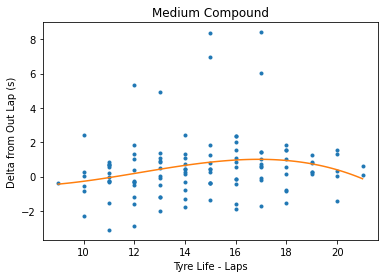

In [7]:
z = np.polyfit(x, y, 3)

p = np.poly1d(z)

xp = np.linspace(x.min(), x.max(), 100)
plt.ylabel("Delta from Out Lap (s)")
plt.xlabel("Tyre Life - Laps")
plt.title("Medium Compound")
plt.plot(x, y, '.', xp, p(xp), '-')
plt.show()

In [9]:
pr_soft.head()
X_soft = pr_soft["TyreLife"]
y_soft = pr_soft["OL_delta"]

xs = X_soft
ys = y_soft

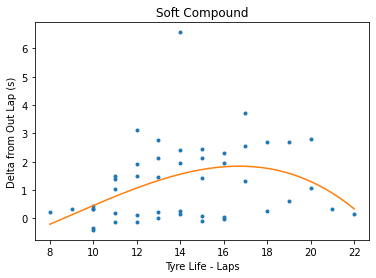

In [10]:
zs = np.polyfit(xs, ys, 3)

ps = np.poly1d(zs)

xps = np.linspace(xs.min(), xs.max(), 100)
plt.ylabel("Delta from Out Lap (s)")
plt.xlabel("Tyre Life - Laps")
plt.title("Soft Compound")
plt.plot(xs, ys, '.', xps, ps(xps), '-')
plt.show()

In [11]:
#long stint on medium
pr_hard.head()
X_hard = pr_hard["TyreLife"]
y_hard = pr_hard["OL_delta"]

xh = X_hard
yh = y_hard

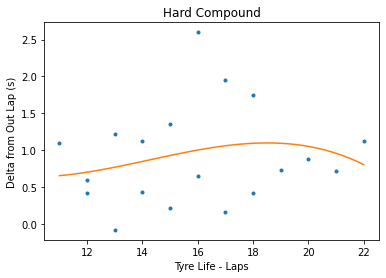

In [12]:
zh = np.polyfit(xh, yh, 3)

ph = np.poly1d(zh)

xph = np.linspace(xh.min(), xh.max(), 100)
plt.ylabel("Delta from Out Lap (s)")
plt.xlabel("Tyre Life - Laps")
plt.title("Hard Compound")
plt.plot(xh, yh, '.', xph, ph(xph), '-')
plt.show()

The observed curves show that by Lap 16 of the tyre's life, the Soft's delta from the out lap is higher than than the Medium's delta from the out lap. 

In [21]:
# making predictions from generated models

# 5 Laps
# hard tyre
hard5 = ph(5)
# medium tyre
medium5 = p(5)
# soft tyre
soft5= ps(5)

# 10 Laps
# hard tyre
hard10 = ph(10)
# medium tyre
medium10 = p(10)
# soft tyre
soft10 = ps(10)

# 15 Laps
# hard tyre
hard15 = ph(15)
# medium tyre
medium15 = p(15)
# soft tyre
soft15 = ps(15)

# 20 Laps
# hard tyre
hard20 = ph(20)
# medium tyre
medium20 = p(20)
# soft tyre
soft20 = ps(20)

delt_df = (
    [hard5, medium5, soft5],
    [hard10, medium10, soft10], 
      [hard15, medium15, soft15], 
      [hard20, medium20, soft20])

delt_df

([1.288827579015284, -0.1612647950524395, -1.0750182939169655],
 [0.6368011708440382, -0.2713822228647813, 0.45022447365517815],
 [0.9286567730475581, 0.842573555314984, 1.721572090510173],
 [1.0517592447175836, 0.3977908239919006, 1.2996685984031446])

Based on these predictions, the Medium tyre looks to be the compound that performs for stints targeting the 15-20 lap range (two-stop strategy). 

Based on the limited data from the Hard tyre, lap times closer to the outlap are predicted around the 10 lap mark, but at this point it is 0.63 seconds off pace. The tyre then degrades and lap times 0.92 seconds off outlap pace are predicted at the 15 lap mark of the tyre's life.

The Medium compound looks to be the best performing compound, as predicted pace is 0.27 seconds quicker than the outlap at lap 10 of the tyre's life. By lap 15, the predicted delta is 0.84 seconds, but by lap 20, lap times 0.39 seconds slower than the out lap are predicted.

The Soft compound degrades quickly. By lap 10 the predicted delta from the out lap is 0.45 seconds. At 15 laps the predicted delta jumps up to 1.7 seconds, before decreasing to 1.29 seconds at lap 20 of the stint. 

In [22]:
delt_df = pd.DataFrame(data=delt_df, index=["5 Laps", "10 Laps", "15 Laps", "20 Laps"], columns=["Hard", "Medium", "Soft"])
delt_df

,Hard,Medium,Soft
5 Laps,1.288828,-0.161265,-1.075018
10 Laps,0.636801,-0.271382,0.450224
15 Laps,0.928657,0.842574,1.721572
20 Laps,1.051759,0.397791,1.299669


Looking specifically at Gasly's early race incident, it would be reasonable to project that the first stint on the Medium would be targeted to last ~18-20 laps depending on how other team's reacted. 

Gasly's first stop took a total of 38.33 seconds (from pit entry to exit), meaning he was 38.33 seconds behind planned pace. 

If Gasly fitted the Soft on Lap 5 instead of the Hard, and ran the stop until lap 15 (compared to running the Hard until Lap 19)...  

In [61]:
# using lap time predictor model from above to predict outlap
predicted_lt_s_out_lap = regr.predict([[0,1,1]])

s1 = predicted_lt_s_out_lap
s2 = predicted_lt_s_out_lap + ps(2)
s3 = predicted_lt_s_out_lap + ps(3)
s4 = predicted_lt_s_out_lap + ps(4)
s5 = predicted_lt_s_out_lap + ps(5)
s6 = predicted_lt_s_out_lap + ps(6)
s7 = predicted_lt_s_out_lap + ps(7)
s8 = predicted_lt_s_out_lap + ps(8)
s9 = predicted_lt_s_out_lap + ps(9)
s10 = predicted_lt_s_out_lap + ps(10)
stop = 24.33
predicted_lt_m_out_lap = regr.predict([[1,0,1]]) # medium out lap time
m1 = predicted_lt_m_out_lap 
m2 = predicted_lt_m_out_lap + p(2)
m3 = predicted_lt_m_out_lap + p(3)
m4 = predicted_lt_m_out_lap + p(4)
m5 = predicted_lt_m_out_lap + p(5)

proj = [s1 + s2 + s3 + s4 + s5 + s6 + s7 + s8 + s9 + s10 + stop + m1 + m2 +  m3 + m4 + m5]

actual = pd.read_csv('gp_2021_lap_sector_times_deltas.csv')
actual = actual[actual["gp"] == 'Bahrain Grand Prix']
actual = actual[actual["session"] == 'R']
actual = actual[actual['LapNumber'] > 5]
actual = actual[actual['LapNumber'] < 21]
actual = actual[actual['Driver'] == 'GAS']
actual = actual["LapTime"]
actual

2063     96.677
2073     96.954
2082     97.424
2091     97.030
2101     97.375
2111     97.517
2121     98.054
2131     97.874
2140     98.302
2149     98.001
2158     97.993
2167     98.415
2176     99.272
2185    100.838
2194    119.290
Name: LapTime, dtype: float64

In [62]:
# same 15 lap span
#Projected total time laps 5-20 = 
proj = sum(proj)
#Actual total time laps 5-20 = 
actual = sum(actual)
print(proj, actual)

[[1450.42450395]] 1491.01600011


In [64]:
model_delta = proj - actual
model_delta

array([[-40.59149616]])

## Results

According to the results from the model, covering the same lap span from laps 6-21, if Gasly fitted the soft he would've been 40 seconds than where he was observed during the race. This would've put him behind his teammate Tsunoda at lap 21, running in 15th.



## Tsunoda's Race

Avoiding early lap incidents, Tsunoda was on pace to make a two stop strategy work. The team elected to go on Hard - Hard for the two stops. This was surprising as the Medium compound would've worked better than the Hard according to the prediction model built and trained off practice data. 

However, at this point of the race, data on all compounds was avaliable. Therefore, to analyze the decision made for Tsunoda's second and third stops, the race data was used to train the models.

Tsunoda first pitted at lap 15, then again at lap 33. 

In [75]:
# second stint
## Polynomial Regression 
ts_fs = pd.read_csv('gp_2021_lap_sector_times_deltas.csv')
ts_fs = ts_fs[ts_fs["gp"] == 'Bahrain Grand Prix']
ts_fs = ts_fs[ts_fs["session"] == 'R']
ts_fs = ts_fs[ts_fs['track_clear'] == 'yes']
ts_fs = ts_fs[ts_fs['LapNumber'] < 15]
ts_fs = ts_fs[ts_fs.PitInTime.isnull()]
ts_fs = ts_fs[ts_fs.PitOutTime.isnull()]
#pr_at = pr_at.dropna(subset=['PitInTime', 'PitOutTime'])

ts_medf = ts_fs[ts_fs['Compound'] == 'MEDIUM']
ts_softf = ts_fs[ts_fs['Compound'] == 'SOFT']
ts_hardf = ts_fs[ts_fs['Compound'] == 'HARD']

# third stint
## Polynomial Regression 
ts_ss = pd.read_csv('gp_2021_lap_sector_times_deltas.csv')
ts_ss = ts_ss[ts_ss["gp"] == 'Bahrain Grand Prix']
ts_ss = ts_ss[ts_ss["session"] == 'R']
ts_ss = ts_ss[ts_ss['track_clear'] == 'yes']
ts_ss = ts_ss[ts_ss['LapNumber'] < 33]
ts_ss = ts_ss[ts_ss.PitInTime.isnull()]
ts_ss = ts_ss[ts_ss.PitOutTime.isnull()]
#pr_at = pr_at.dropna(subset=['PitInTime', 'PitOutTime'])

ts_meds = ts_ss[ts_ss['Compound'] == 'MEDIUM']
ts_softs = ts_ss[ts_ss['Compound'] == 'SOFT']
ts_hards = ts_ss[ts_ss['Compound'] == 'HARD']

In [61]:
ts_medf = ts_medf.dropna(subset=['TyreLife', 'OL_LapTime', 'OL_delta'])
ts_hardf = ts_hardf.dropna(subset=['TyreLife', 'OL_LapTime', 'OL_delta'])

ts_medf

,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,...,yellow_flag,safety_car,red_flag,vsc_deployed,vsc_ending,LL_LapTime,LL_delta,out_lap,OL_LapTime,OL_delta
59,00:50:49.660000,33,95.902,7,1,NaN,NaN,30.846,41.378,23.678,...,no,no,no,no,no,95.982,-0.080,6.0,95.982,-0.080
67,00:52:25.692000,33,96.032,8,1,NaN,NaN,31.016,41.266,23.750,...,no,no,no,no,no,95.902,0.130,6.0,95.982,0.050
76,00:54:01.704000,33,96.012,9,1,NaN,NaN,30.988,41.271,23.753,...,no,no,no,no,no,96.032,-0.020,6.0,95.982,0.030
85,00:55:37.879000,33,96.175,10,1,NaN,NaN,30.984,41.378,23.813,...,no,no,no,no,no,96.012,0.163,6.0,95.982,0.193
93,00:57:14.058000,33,96.179,11,1,NaN,NaN,30.868,41.427,23.884,...,no,no,no,no,no,96.175,0.004,6.0,95.982,0.197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4518,00:56:04.161000,5,98.100,10,1,NaN,NaN,31.109,42.546,24.445,...,no,no,no,no,no,99.358,-1.258,6.0,97.484,0.616
4520,00:57:42.345000,5,98.184,11,1,NaN,NaN,31.353,42.395,24.436,...,no,no,no,no,no,98.100,0.084,6.0,97.484,0.700
4522,00:59:20.514000,5,98.169,12,1,NaN,NaN,31.238,42.477,24.454,...,no,no,no,no,no,98.184,-0.015,6.0,97.484,0.685
4524,01:00:58.564000,5,98.050,13,1,NaN,NaN,31.300,42.368,24.382,...,no,no,no,no,no,98.169,-0.119,6.0,97.484,0.566


In [62]:
# prediction models based on data avaliable at each pit lap 

#second stint on medium
ts_medf.head()
X_medf = ts_medf["TyreLife"]
y_medf = ts_medf["OL_delta"]

xf = X_medf
yf = y_medf

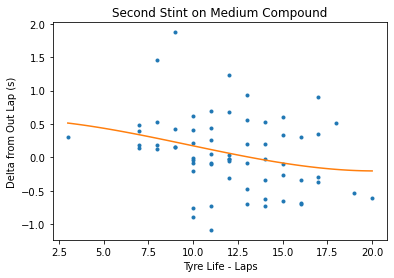

In [63]:
zf = np.polyfit(xf, yf, 3)

pf = np.poly1d(zf)

xpf = np.linspace(xf.min(), xf.max(), 100)
plt.ylabel("Delta from Out Lap (s)")
plt.xlabel("Tyre Life - Laps")
plt.title("Second Stint on Medium Compound")
plt.plot(xf, yf, '.', xpf, pf(xpf), '-')
plt.show()

In [59]:
# prediction models based on data avaliable at each pit lap 

#second stint on hard
ts_hardf.head()
X_hardf = ts_hardf["TyreLife"]
y_hardf = ts_hardf["OL_delta"]

xfh = X_hardf
yfh = y_hardf

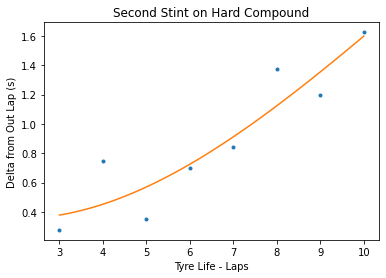

In [60]:
zfh = np.polyfit(xfh, yfh, 3)

pfh = np.poly1d(zfh)

xpfh = np.linspace(xfh.min(), xfh.max(), 100)
plt.ylabel("Delta from Out Lap (s)")
plt.xlabel("Tyre Life - Laps")
plt.title("Second Stint on Hard Compound")
plt.plot(xfh, yfh, '.', xpfh, pfh(xpfh), '-')
plt.show()

The data avaliable shows that by lap 10 on the Hard tyre, the delta from the push lap has suprpassed 1 second. On lap 10 of the Medium compounds life, the delta to the push lap is projected to be < 0.5 seconds from the push lap. 

In [76]:
ts_meds = ts_meds.dropna(subset=['TyreLife', 'OL_LapTime', 'OL_delta'])
ts_hards = ts_hards.dropna(subset=['TyreLife', 'OL_LapTime', 'OL_delta'])

ts_meds

,Time,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,Sector3Time,...,yellow_flag,safety_car,red_flag,vsc_deployed,vsc_ending,LL_LapTime,LL_delta,out_lap,OL_LapTime,OL_delta
59,00:50:49.660000,33,95.902,7,1,NaN,NaN,30.846,41.378,23.678,...,no,no,no,no,no,95.982,-0.080,6.0,95.982,-0.080
67,00:52:25.692000,33,96.032,8,1,NaN,NaN,31.016,41.266,23.750,...,no,no,no,no,no,95.902,0.130,6.0,95.982,0.050
76,00:54:01.704000,33,96.012,9,1,NaN,NaN,30.988,41.271,23.753,...,no,no,no,no,no,96.032,-0.020,6.0,95.982,0.030
85,00:55:37.879000,33,96.175,10,1,NaN,NaN,30.984,41.378,23.813,...,no,no,no,no,no,96.012,0.163,6.0,95.982,0.193
93,00:57:14.058000,33,96.179,11,1,NaN,NaN,30.868,41.427,23.884,...,no,no,no,no,no,96.175,0.004,6.0,95.982,0.197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4536,01:10:50.423000,5,99.071,19,1,NaN,NaN,31.805,42.540,24.726,...,no,no,no,no,no,98.717,0.354,6.0,97.484,1.587
4538,01:12:30.007000,5,99.584,20,1,NaN,NaN,32.104,42.843,24.637,...,no,no,no,no,no,99.071,0.513,6.0,97.484,2.100
4540,01:14:10.003000,5,99.996,21,1,NaN,NaN,31.965,43.004,25.027,...,no,no,no,no,no,99.584,0.412,6.0,97.484,2.512
4542,01:15:50.757000,5,100.754,22,1,NaN,NaN,33.283,42.868,24.603,...,no,no,no,no,no,99.996,0.758,6.0,97.484,3.270


In [77]:
# prediction models based on data avaliable at each pit lap 

#third stint on medium
ts_meds.head()
X_meds = ts_meds["TyreLife"]
y_meds = ts_meds["OL_delta"]

xs = X_meds
ys = y_meds

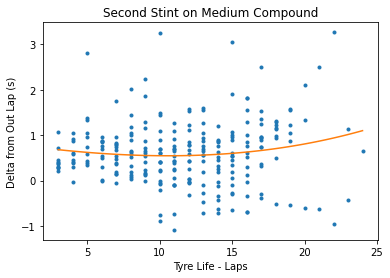

In [78]:
zs = np.polyfit(xs, ys, 3)

ps = np.poly1d(zs)

xps = np.linspace(xs.min(), xs.max(), 100)
plt.ylabel("Delta from Out Lap (s)")
plt.xlabel("Tyre Life - Laps")
plt.title("Second Stint on Medium Compound")
plt.plot(xs, ys, '.', xps, ps(xps), '-')
plt.show()

In [79]:
# prediction models based on data avaliable at each pit lap 

#third stint on hard
ts_hards.head()
X_hards = ts_hards["TyreLife"]
y_hards = ts_hards["OL_delta"]

xsh = X_hards
ysh = y_hards

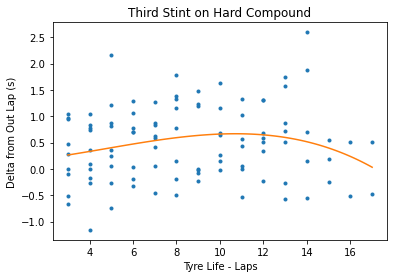

In [80]:
zsh = np.polyfit(xsh, ysh, 3)

psh = np.poly1d(zsh)

xpsh = np.linspace(xsh.min(), xsh.max(), 100)
plt.ylabel("Delta from Out Lap (s)")
plt.xlabel("Tyre Life - Laps")
plt.title("Third Stint on Hard Compound")
plt.plot(xsh, ysh, '.', xpsh, psh(xpsh), '-')
plt.show()

Now that more data has become avaliable, and is more in kin with developed track conditions, the Hard tyere seems to be working effectively. At lap 10 of the tyre's life it is still within 1 second of the push lap delta, similar to the Medium. The lap times also decrease as the stint progresses. This could be due to the car being the lightest it is during the race, as fuel has been burned off. 

In [84]:
# making predictions from generated models

# 5 Laps - third stint data avaliable
# hard tyre 
hard5f = pfh(5)
# medium tyre
medium5f = pf(5)

# 10 Laps
# hard tyre
hard10f = pfh(10)
# medium tyre
medium10f = pf(10)


# 15 Laps
# hard tyre
hard15f = pfh(15)
# medium tyre
medium15f = pf(15)


# 20 Laps
# hard tyre
hard20f = pfh(20)
# medium tyre
medium20f = pf(20)

# 5 Laps - second stint data avaliable
# hard tyre 
hard5s = psh(5)
# medium tyre
medium5s = ps(5)

# 10 Laps
# hard tyre
hard10s = psh(10)
# medium tyre
medium10s = ps(10)

# 15 Laps
# hard tyre
hard15s = psh(15)
# medium tyre
medium15s = ps(15)

# 20 Laps
# hard tyre
hard20s = psh(20)
# medium tyre
medium20s = ps(20)

delt_dff = (
    [hard5f, medium5f],
    [hard10f, medium10f], 
      [hard15f, medium15f], 
      [hard20f, medium20f])

delt_dff

delt_dfs = (
    [hard5s, medium5s],
    [hard10s, medium10s], 
      [hard15s, medium15s], 
      [hard20s, medium20s])

In [86]:
delt_dff = pd.DataFrame(data=delt_dff, index=["5 Laps", "10 Laps", "15 Laps", "20 Laps"], columns=["Hard", "Medium"])
delt_dff

,Hard,Medium
5 Laps,0.569896,0.436165
10 Laps,1.598349,0.172737
15 Laps,2.793631,-0.084206
20 Laps,3.383018,-0.203275


In [85]:
delt_dfs = pd.DataFrame(data=delt_dfs, index=["5 Laps", "10 Laps", "15 Laps", "20 Laps"], columns=["Hard", "Medium"])
delt_dfs

,Hard,Medium
5 Laps,0.402766,0.622397
10 Laps,0.662058,0.548308
15 Laps,0.396826,0.601020
20 Laps,-0.892275,0.807348


Given the outputs for the prediction model, the Medium was the right choice based on the data avaliable at the time of the second stop. This model projects faster lap times beyond 20 laps of the tyre's life. 